## Overview

This analysis is based on the attributes of football players released on [FIFA19](https://www.kaggle.com/karangadiya/fifa19)  dataset on Kaggle. The dataset consists of more than 18000 records of player data with around 90 attributes extracted from FIFA database. In this project, we perform data analysis using **Spark packages**.
 

In this analysis, we divide the task into three parts.

- **Part 1**: Exploratory Data Analysis

- **Part 2**: Clustering Analysis, and identify the position profiles of each cluster

- **Part 3**: Classification Analysis, and evaluate the performance of different algorithms using cross validation;

## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-2.4.0-bin-hadoop2.7'

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [ ]:
#only required for jupyter
import os
os.environ['SPARK_HOME'] = 'D:/Projects/spark-2.4.0-bin-hadoop2.7'

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [4]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [5]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.show()

+---------+--------------------+-----------------+--------------------+---+-------------------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+-------------------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+--------

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [6]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [7]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

Getting the summary statistics:

In [8]:
# while taking summary statistics we'll only use players that are present in both FIFA 19 and FIFA 21 databases as we are 
# performing comparison between these two years.
temp_df = df.na.drop(subset=['overall','value_eur'])
temp_df.describe().show()

+-------+-----------------+---------+------------------+--------------------+-----------+--------------------+-----------------+-----------------+--------------------+--------------------+-----------------+------------------+------------------+--------------+------------------------+------------------+------------------+--------------+---------+---------+--------+------------------+-----------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------

From the above statistics, it is seen that the average overall in 2019 is 67.86 and in 2021, it has increased to 68.63. On the other hand, the average potential has decreased from 73.05 to 72.14. In two years, the set of  players started to meet their potential while their potential to grow has decreased.

Checking the statistics (min, mean and max) for Age, Overall:

In [9]:
# use aggregate to calculate min, max and mean

# calculating the minimum age
min_age = df.agg({'Age':'min'}).show()

# calculating the maximum age
max_age = df.agg({'Age':'max'}).show()

# calculating the mean age
mean_age = df.agg({'Age':'avg'}).show()

+--------+
|min(Age)|
+--------+
|      16|
+--------+

+--------+
|max(Age)|
+--------+
|      45|
+--------+

+------------------+
|          avg(Age)|
+------------------+
|25.122205745043114|
+------------------+



In [10]:
# calculating the minimum overall
min_overall = df.agg({'Overall':'min'}).show()

# calculating the maximum overall
max_overall = df.agg({'Overall':'max'}).show()

# calculating the mean overall
mean_overall = df.agg({'Overall':'avg'}).show()

+------------+
|min(Overall)|
+------------+
|          46|
+------------+

+------------+
|max(Overall)|
+------------+
|          94|
+------------+

+-----------------+
|     avg(Overall)|
+-----------------+
|66.23869940132916|
+-----------------+



Finding the position having highest average overall:

In [11]:
# grouping the data first by Position, aggregating the Overall and sorting the data to get the position 
# with highest overall 
df_overall_position = df.groupby('Position').agg({'Overall':'AVG'})
df_overall_position.orderBy(df_overall_position['avg(Overall)'].desc()).take(1)
#df_overall_position.sort('avg(Overall)',ascending=False).first()

[Row(Position='LF', avg(Overall)=73.86666666666666)]

Finding the top 3 countries with highest Avg Overall:

In [12]:
# grouping first by Countries and aggregating the Overall and sorting to get the top 3 countries with 
# highest average overall
df_overall_nationality = df.groupby('Nationality').agg({'Overall':'AVG'})
df_overall_nationality.orderBy(df_overall_nationality['avg(Overall)'].desc()).take(3)

[Row(Nationality='United Arab Emirates', avg(Overall)=77.0),
 Row(Nationality='Central African Rep.', avg(Overall)=73.33333333333333),
 Row(Nationality='Israel', avg(Overall)=72.14285714285714)]

Finding the average potentials on country by position:

In [13]:
# creating a pivot table in which the value of column Nationality is transposed to multiple columns 
pivot_df = df.groupBy('Position').pivot('Nationality').avg('Potential')
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+--------------------+----+------------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+----

Further, viewing the highest average potential for each position.

In [14]:
# renaming the name of a country to avoid syntax error in the next stage
pivot_df = pivot_df.withColumnRenamed('Central African Rep.', 'Central African Republic')

In [15]:
# removing the null position from the dataframe
pivot_df = pivot_df.filter((pivot_df.Position != 'NA'))
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

In [16]:
# finding the maximum value for each row from all columns excluding Position
from pyspark.sql.functions import greatest, col, lit, coalesce, sum
#rowmax = sum([coalesce(col(x), lit(0)) for x in pivot_df.columns])
rowmax = greatest(*[coalesce(col(x), lit(0)) for x in pivot_df.columns[1:]]) 
# adding the column containing maximum values
pivot_df.withColumn('Position(Maximum_Potential)',rowmax).show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

Finding the name of countries with highest average potential for each position is better for understanding. So, we discover the countries having players with highest average potential in each position.  

In [17]:
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# creating a dataframe with a column whose values contain an array of country name and average potential value
pdf = pivot_df.withColumn('Maximum_Avg_Potential',F.explode( \
        F.array([F.array([F.lit(cols), F.col(cols)]) for cols in pivot_df.columns[1:]])))

# creating a dataframe such that the country name and avg potential values are separated in two columns
pdf = pdf.select('Position', F.col('Maximum_Avg_Potential').getItem(0).alias('Country'), \
                 F.col('Maximum_Avg_Potential').getItem(1).cast(T.IntegerType()).alias('Avg_Potential'))

# creating a rank based on average potential for each position in descending order
pdf = pdf.withColumn('Rank', F.rank().over(W.partitionBy('Position').orderBy(F.col('Avg_Potential').desc())))

# selecting rows with rank equal to 1 and this gives the maximum average potential value 
pdf.where('Rank=1').show(pdf.count())

+--------+--------------------+-------------+----+
|Position|             Country|Avg_Potential|Rank|
+--------+--------------------+-------------+----+
|      RF|           Argentina|           87|   1|
|     LWB|            Portugal|           82|   1|
|     LCM|            Slovakia|           87|   1|
|      LM|               Gabon|           82|   1|
|     RDM|      Czech Republic|           83|   1|
|      LF|             Belgium|           86|   1|
|     CAM|            Slovakia|           80|   1|
|     RAM|             Morocco|           86|   1|
|      LB|             Ukraine|           76|   1|
|      LW|        Burkina Faso|           84|   1|
|     RCM|                Mali|           84|   1|
|      GK|             Nigeria|           82|   1|
|      RB|              Panama|           80|   1|
|      RS|            Cameroon|           81|   1|
|     LCB|              Gambia|           81|   1|
|      CM|Central African R...|           85|   1|
|      RW|              Kosovo|

The most interesting finding from the above dataframe is that Dominican Republic has highest average potential for the striker position. It is well known that unlike European, South American or African continent, players from other continents rarely make it to the big stage. So, it can be assumed that player is an outlier, and is among the few players with highest ratings in that country. Not many scouts might be well aware about that striker. It is good to observe that player's game and see if we can sign that player and make one of the prospects in football.

In [18]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
df.createOrReplaceTempView('soccer_analysis')

In [19]:
# viewing the players from Dominican Republic
spark.sql("""
          Select * from soccer_analysis where Nationality = 'Dominican Republic'
          """).show()

+------+----------+---+--------------------+------------------+--------------------+-------+---------+-----------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|      Name|Age|               Photo|       Nationality|                Flag|Overall|Potential|       Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

In [20]:
# viewing the players from Dominican Republic
df.filter(df.Nationality == 'Dominican Republic').show()

+------+----------+---+--------------------+------------------+--------------------+-------+---------+-----------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|      Name|Age|               Photo|       Nationality|                Flag|Overall|Potential|       Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

It is seen that there are only two players from Dominican Republic in the FIFA 2019 database. And, the player with highest potential as a striker is Mariano who is 24 years old. Since, he has already signed for one of the top clubs in Europe, it is hard to lure him away from the club. The release clause of 42.5 millions is moderate considering the current market in 2019. 

Finding the position with highest average potential for Australia: 

In [21]:
# selecting the highest average Potential along with the position for Australia
pivot_df.createOrReplaceTempView('pivot_soccer_analysis')
spark.sql("""
          Select Position, Australia from pivot_soccer_analysis Order By Australia Desc Limit 1
          """).show(30)

+--------+---------+
|Position|Australia|
+--------+---------+
|     RDM|     77.0|
+--------+---------+



In [22]:
# selecting the highest average Potential along with the position for Australia
pivot_df.orderBy(pivot_df['Australia'].desc())['Position','Australia'].first()

Row(Position='RDM', Australia=77.0)

In [23]:
# finding the name of the Australian player with highest average potential 
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' And Position = 'RDM'
          """).show()

+------+---------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|     Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

In [24]:
# finding the name of the Australian player with highest average potential 
df.filter((df.Nationality == 'Australia') & (df.Position == 'RDM')).show()

+------+---------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|     Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate

Finding the under 20 players with the highest and worst potential

In [25]:
# filtering the dataset based on age (under 20) and then arranging the overall in descending order
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Overall Desc
          """).show()

+------+-------------------+---+--------------------+-------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|               Name|Age|               Photo|  Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [26]:
# filtering the dataset based on age (under 20) and then arranging the overall in descending order
df.filter(df['Age'] < 20).sort('Overall', ascending=False).show() 

+------+-------------------+---+--------------------+-------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|               Name|Age|               Photo|  Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

Best player under 20 (Kylian Mbappe) and he has the best potential as well 

In [27]:
# under 20 players having worst potential
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Potential Asc
          """).show()

+------+-------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [28]:
# under 20 players having worst potential
df.filter(df['Age'] < 20).sort('Potential', ascending=True).show() 

+------+-------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [29]:
# finding the Australian player with highest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Desc
          """).show()

+------+-------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+--------------------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Ski

In [30]:
# finding the Australian player with highest potential
df.filter(df.Nationality.isin('Australia')).sort('Potential', ascending=False).show()

+------+-------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+--------------------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Ski

In [31]:
# finding the Australian player with lowest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Asc
          """).show()

+------+--------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|          Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Move

In [32]:
# finding the Australian player with lowest potential
df.filter(df.Nationality.isin('Australia')).sort('Potential', ascending=True).show()

+------+--------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|          Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Move

**Relationship between age of players with their potential and overall**

Finding relationships between age and average potential and age and average overall:

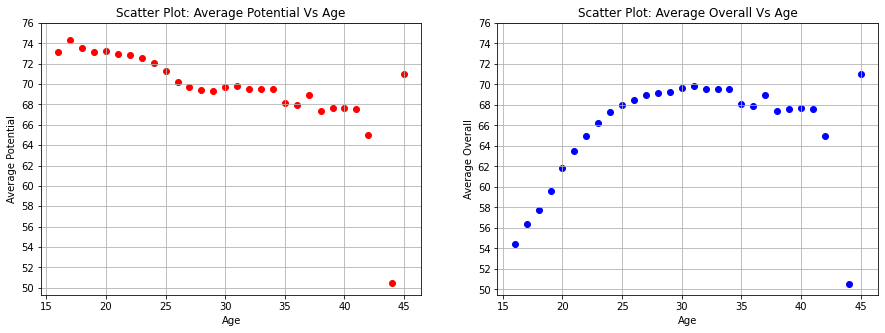

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# creating two dataframes that hold Age with Average Potential and Average Overall along with renaming the aggregated columns
df_age_potential = df.groupby('Age').avg('Potential').withColumnRenamed('avg(Potential)', 'Average Potential')
df_age_overall = df.groupby('Age').avg('Overall').withColumnRenamed('avg(Overall)', 'Average Overall')

# first, converting the above two pyspark dataframes to Pandas and storing in a variable
# then, concatenating those two pandas dataframe setting axis 1 i.e. by column
data = [df_age_potential.select('*').toPandas(),df_age_overall.select('Average Overall').toPandas()]
df_age = pd.concat(data, axis=1)
df_age.head(5)

# plotting 
# creating two subplots for plotting Average Potential and Average Overall against Age
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(15,5))
# using first scatter plot for Average Potential and the second for Average Overall 
ax1.scatter(df_age['Age'], df_age['Average Potential'], color='r')
ax2.scatter(df_age['Age'], df_age['Average Overall'], color='b')
# setting y ticks, labels and titles for both plots
ax1.set_yticks(list(range(50,78,2)))
ax2.set_yticks(list(range(50,78,2)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Average Potential')
ax1.set_title('Scatter Plot: Average Potential Vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Average Overall')
ax2.set_title('Scatter Plot: Average Overall Vs Age')
# enabling grid view
ax1.grid(True)
ax2.grid(True)
plt.show()

It is seen from the above scatter plots that average potential decreases with age while average overall increases with age. At age 31, both average potential and average overall meet at the same point (70). So, by the age of 31, players will realise their full potential. After 31, both average potential and average overall declines. However, we can see that at 45 both average potential and overall reached a high point which can be considered as an outlier.

In [34]:
# finding the correlation matrix
df_age.corr(method ='pearson') 

,Age,Average Potential,Average Overall
Age,1.000000,-0.703127,0.370369
Average Potential,-0.703127,1.000000,0.199843
Average Overall,0.370369,0.199843,1.000000


The above correlation matrix reflects the same relationship that can be seen in scatter plots.

Dealing Missing Values:

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in a desired format.

In [35]:
# checking the missing values
from pyspark.sql.functions import count, col
null_values_count = df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 48 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [36]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = df.filter(df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analysis.

Handling of missing values in Value_2019(M) column:

In [37]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is NUll
          """).show()

+------+---------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Mo

In [38]:
df.filter(F.col('value_eur').isNull()).show()

+------+---------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Mo

It is seen that although we have missing values for players in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

In [39]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+------+-------------+---+--------------------+--------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|   Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill 

In [40]:
df.filter(df['value(M)'].contains('K')).show()

+------+-------------+---+--------------------+--------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|   Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill 

All the issues seen above have to be dealt before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

Creating Pipelines for Data Preprocessing:

In this stage, we create two pipelines for regression and classification tasks. Depending on the tasks, certain operations are omitted in the pipeline. For example, for classification tasks, we will not use ValueImputer function to impute missing values for players monetary values in 2019 and 2021 as classification is made independent of these two columns.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [41]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"
!mv "/content/FIFA_2019/encoder.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 116 (delta 56), reused 73 (delta 35), pack-reused 0
Receiving objects: 100% (116/116), 4.75 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [42]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor.ValueImputer()
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()
# defining the stage that generates labels based on the potential to grow in two years
classification_target = target_generator.GrowthGenerator()

DataFrame for Regression:

In [43]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_regression.fit(df)
regression_df = pipeline_model.transform(df)

In [44]:
regression_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): double (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)

In [45]:
regression_df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+------------+--------------+-------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|               Club|           Club Logo|Value_2019(M)|wage(K)|S

DataFrame for Classification

In [46]:
# creating a pipeline to generate dataframe for classification
pipeline_classification = Pipeline(stages=[value_manipulation, value_standardisation, classification_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model2 = pipeline_classification.fit(df)
classification_df = pipeline_model2.transform(df)

In [47]:
classification_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): float (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)


In [48]:
classification_df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+------------+--------------+-------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|               Club|           Club Logo|Value_2019(M)|wage(K)|Specia

## Part 2 - Unsupervised Learning: Kmeans




### 2.1 Data Preparation
***

In this stage, we perform clustering of players after grouping them in three groups, DEF, MID and FWD, based on their attributes. Later, we analyse what type of positions are mainly included in each cluster. Also, for clustering purpose, we use classification_df dataframe as in regression_df we have removed some records for players containing missing values in Value column, and since Value column is not relevant in clustering having missing values in that column won't affect our cluster analysis.

In [ ]:
# removing the position GK and storing in a new dataframe
df_filtered = df.filter(df['Position'] != 'GK')
# viewing the unique values in the filtered dataframe and check if GK has been removed
df_filtered.count()

16122

In [49]:
# rough
regression_df.count()

16010

In [50]:
df.count()

18207

In [51]:
classification_df.count()

16122

To make the later stage easier, we define the position group by using the position feature (attributes on Position).
- DEF = [LB,LWB,RB,LCB,RCB,CB,RWB] ,
- FWD = [RF,LF,LW,RS,RW,LS,CF,ST] ,
- MID = [LCM,LM,RDM,CAM,RAM,RCM,CM,CDM,RM,LAM,LDM]

In [52]:
from pyspark.sql.functions import when,col

# creating a list of specific positions
DEF = ['LB','LWB','RB','LCB','RCB','CB','RWB']
FWD = ['RF','LF','LW','RS','RW','LS','CF','ST']  
MID = ['LCM','LM','RDM','CAM','RAM','RCM','CM','CDM','RM','LAM','LDM'] 

# creating a new column which stores values based on conditions
df_kmeans_new = classification_df.withColumn('Position_Group',F.when(F.col('Position').isin(DEF),'DEF')\
                                  .when(F.col('Position').isin(FWD),'FWD')\
                                  .when(F.col('Position').isin(MID),'MID').otherwise(0))
# checking if correct group has been assigned for specific playing positions
df_kmeans_new.select('Position','Position_Group').distinct().show(50)

+--------+--------------+
|Position|Position_Group|
+--------+--------------+
|     LCB|           DEF|
|      LS|           FWD|
|     RCB|           DEF|
|      ST|           FWD|
|      CF|           FWD|
|     RAM|           MID|
|     RCM|           MID|
|     LCM|           MID|
|      CM|           MID|
|      LF|           FWD|
|      RW|           FWD|
|      LB|           DEF|
|     CDM|           MID|
|     LDM|           MID|
|     RDM|           MID|
|      LM|           MID|
|     LWB|           DEF|
|      RB|           DEF|
|      LW|           FWD|
|      RS|           FWD|
|     LAM|           MID|
|     RWB|           DEF|
|      RM|           MID|
|      CB|           DEF|
|      RF|           FWD|
|     CAM|           MID|
+--------+--------------+



Now, we create a feature vector from different features of a player. We only take the feature vector for clustering purpose removing the Position_Group and Position to create the feature for Kmeans




In [53]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
# selecting only ID and features, which is the feature vector in a new dataframe
df_kmeans = vec_assembler.transform(df_kmeans_new).select('ID','features')
df_kmeans.show(3)

+------+--------------------+
|    ID|            features|
+------+--------------------+
|158023|[173.736,72.12112...|
| 20801|[188.976,83.00733...|
|190871|[179.832,68.0388,...|
+------+--------------------+
only showing top 3 rows



Now we plot the elbow plot to determine the optimum number of clusters for our dataset. We test with a range of cluster numbers from 2 to 20.

In [54]:
# creating an array to store the within sum of squared errors for different cluster numbers
cost = np.zeros(21)

for k in range(2,21):
    # initialising k means with seed value to enable reproducability and fitting the model to df_kmeans
    kmeans_iter = KMeans().setK(k).setSeed(2020)
    model = kmeans_iter.fit(df_kmeans)
    # storing the within sum of squared errors in the cost array
    cost[k] = model.computeCost(df_kmeans)

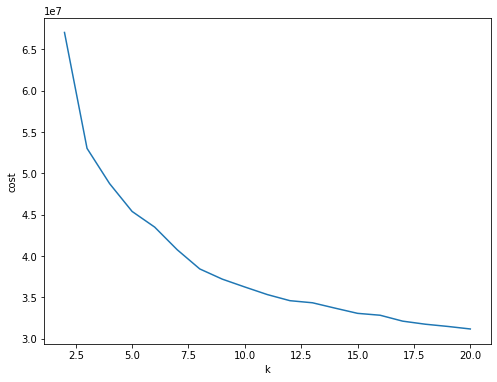

In [55]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')

#plotting the within sum of squared errors for each cluster number
ax.plot(range(2,21),cost[2:21])

From the above plot, it can be seen that after k=8 there is not a steep decline in the cost (sum of squared error), so we take k=8 as our elbow point. For clustering, we take 8 as the ideal number of clusters.


### 2.2 K-Means
***



In [56]:
k = 8

kmeans = KMeans().setK(k).setSeed(2020)
model = kmeans.fit(df_kmeans)
# assigning the cluster centers
print('***Cluster Centres***')
cluster_centers = model.clusterCenters()
for i in cluster_centers:
  print(i) # printing the centers

***Cluster Centres***
[185.31495491  79.65976768  32.77394408  24.74895895  62.62522308
  50.86079714  27.50089233  36.57406306  29.23022011  28.58953004
  43.74776919  47.08685306  55.09220702  56.6097561   49.00237954
  56.5056514   52.90422368  42.62938727  68.55978584  61.56692445
  74.70493754  26.34622249  62.74538965  60.69363474  28.58060678
  34.55205235  37.14931588  53.29565735  61.76085663  64.85246877
  62.20107079]
[173.32242564  74.68080605  68.73818577  59.31504617  60.89570885
  74.44486692  59.38511678  71.22053232  68.15209125  63.67028789
  71.1922868   73.79739272  68.86040196  68.0032591   71.15643672
  71.85659967  70.43400326  73.11406844  68.26941879  76.1667572
  69.41879413  68.24551874  71.51330798  68.88919066  66.30852797
  70.11624117  61.4741988   71.4263987   66.1700163   68.99022271
  65.78815861]
[171.31033837  71.90209742  51.98690836  33.60775428  51.13141994
  57.00906344  32.35397784  55.21903323  40.13796576  35.9572004
  50.55991944  56.16968781

In [57]:
# assigning the unique column to a cluster center while taking off the features column using transform method
predictions = model.transform(df_kmeans).select('ID','prediction')
# assigning the list of predicted ids
predictions_list = predictions.collect()

# # instantiating a sqlContext object
# sqlContext = SQLContext(spark)
# creating a dataframe using SQLContext object
df_prediction = sqlContext.createDataFrame(predictions_list)
df_prediction.show(10)

+------+----------+
|    ID|prediction|
+------+----------+
|158023|         5|
| 20801|         5|
|190871|         5|
|192985|         1|
|183277|         5|
|177003|         1|
|176580|         5|
|155862|         1|
|188545|         5|
|182521|         1|
+------+----------+
only showing top 10 rows



In [58]:
# joining the original dataframe containing Position_Group to the prediction dataframe using common column ID
df_prediction_complete = df_prediction.join(df_kmeans_new,'ID')
df_prediction_complete.show()

+------+----------+-----------------+---+--------------------+--------------+--------------------+------------+--------------+--------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+--------------+
|    ID|prediction|             Name|Age|               Photo|   Nationality|                Flag|Overall_2019|Potential_2019|                Club|     

In [59]:
# counting the position group present in each cluster 
df_prediction_complete.groupby('prediction','Position_Group').agg(F.count('ID')).sort('prediction').show(30)

+----------+--------------+---------+
|prediction|Position_Group|count(ID)|
+----------+--------------+---------+
|         0|           MID|       22|
|         0|           FWD|        1|
|         0|           DEF|     1659|
|         1|           MID|     1326|
|         1|           DEF|      475|
|         1|           FWD|       40|
|         2|           DEF|     1303|
|         2|           MID|      666|
|         2|           FWD|       11|
|         3|           DEF|       11|
|         3|           MID|     1452|
|         3|           FWD|      510|
|         4|           MID|     1619|
|         4|           FWD|       59|
|         4|           DEF|     1194|
|         5|           FWD|     1144|
|         5|           DEF|        5|
|         5|           MID|     1267|
|         6|           FWD|        4|
|         6|           MID|      352|
|         6|           DEF|     1219|
|         7|           MID|      134|
|         7|           FWD|     1649|
+----------+

## Part 3 - Supervised Learning: Classification on Position_Group


In this part, we try to predict the position group of the player.

### 3.1 Data Preparation

We remove the feature of position and only use the skill set features and the cluster results from Kmeans as the input. The target for classification is "Position_Group".
***

In [60]:
# renaming the column prediction in our dataframe as Cluster and reflecting the changes in a new dataframe df_kmeans_pred
df_kmeans_pred = df_prediction_complete.withColumnRenamed('prediction', 'Cluster')
df_kmeans_pred.show(5)

+------+-------+-------------+---+--------------------+-----------+--------------------+------------+--------------+--------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+--------------+
|    ID|Cluster|         Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|                Club|           Club Logo|Valu

In [62]:
# selecting the attributes to get a feature vector later
features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Cluster']


vec_assembler_ = VectorAssembler(inputCols=features_col, outputCol='features')
# this dataframe contains the feature vector generated from players' attributes and their clusters
df_class = vec_assembler_.transform(df_kmeans_pred).select('features','Position_Group')
df_class.show(3)

+--------------------+--------------+
|            features|Position_Group|
+--------------------+--------------+
|[173.736,68.0388,...|           FWD|
|[195.072,87.99684...|           DEF|
|[185.928,79.83219...|           DEF|
+--------------------+--------------+
only showing top 3 rows



Performing feature scaling. For this, we use standard scaling on the features.

In [63]:
from pyspark.ml.feature import StandardScaler

standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
raw_data = standardscaler.fit(df_class).transform(df_class)
raw_data.select('features', 'Scaled_features','Position_Group').show(5)

+--------------------+--------------------+--------------+
|            features|     Scaled_features|Position_Group|
+--------------------+--------------------+--------------+
|[173.736,68.0388,...|[12.9261363965245...|           FWD|
|[195.072,87.99684...|[14.5135566557469...|           DEF|
|[185.928,79.83219...|[13.8332336875087...|           DEF|
|[179.832,68.0388,...|[13.3796850420166...|           MID|
|[173.736,69.85316...|[12.9261363965245...|           DEF|
+--------------------+--------------------+--------------+
only showing top 5 rows



In Spark, we can not use string as Target data type. So, encoding the Position_Group column by using following encoding: 

FWD = 0
DEF = 1
MID = 2

In [64]:
raw_data_encode = raw_data.withColumn('Target',when(col('Position_Group') == 'DEF', 1)
      .when(col('Position_Group')== 'FWD', 0)
      .otherwise(2))
raw_data_encode.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[173.736,68.0388,...|           FWD|[12.9261363965245...|     0|
|[195.072,87.99684...|           DEF|[14.5135566557469...|     1|
|[185.928,79.83219...|           DEF|[13.8332336875087...|     1|
|[179.832,68.0388,...|           MID|[13.3796850420166...|     2|
|[173.736,69.85316...|           DEF|[12.9261363965245...|     1|
|[176.784,74.84268...|           FWD|[13.1529107192706...|     0|
|[182.88,77.11064,...|           MID|[13.6064593647627...|     2|
|[155.7528,73.9354...|           DEF|[11.5881678923229...|     1|
|[182.88,83.007336...|           MID|[13.6064593647627...|     2|
|[188.976,78.92500...|           FWD|[14.0600080102548...|     0|
|[179.832,69.85316...|           DEF|[13.3796850420166...|     1|
|[198.12,92.98636,...|           FWD|[14.7403309784929...|     0|
|[182.88,7

### 3.2 Training Test Evaluation
***

Splitting the data into train/Test, and evaluating the model performance.

In [65]:
train, test = raw_data_encode.randomSplit([0.7, 0.3], seed=2020)

In [66]:
test.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[155.448,64.86365...|           DEF|[11.5654904600483...|     1|
|[155.448,68.0388,...|           MID|[11.5654904600483...|     2|
|[155.448,73.93549...|           MID|[11.5654904600483...|     2|
|[155.448,74.84268...|           FWD|[11.5654904600483...|     0|
|[155.448,79.83219...|           DEF|[11.5654904600483...|     1|
|[155.7528,64.8636...|           FWD|[11.5881678923229...|     0|
|[155.7528,78.9250...|           MID|[11.5881678923229...|     2|
|[170.688,63.95647...|           MID|[12.6993620737785...|     2|
|[170.688,69.85316...|           MID|[12.6993620737785...|     2|
|[173.736,64.86365...|           FWD|[12.9261363965245...|     0|
|[173.736,68.0388,...|           FWD|[12.9261363965245...|     0|
|[173.736,68.0388,...|           DEF|[12.9261363965245...|     1|
|[176.784,

In [67]:
# using logistic regression for classification
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=10)
model=lr.fit(train)

predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select('Target', 'prediction').show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [68]:
predict_test.show(10)

+--------------------+--------------+--------------------+------+--------------------+--------------------+----------+
|            features|Position_Group|     Scaled_features|Target|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+------+--------------------+--------------------+----------+
|[155.448,64.86365...|           DEF|[11.5654904600483...|     1|[-2.8578031569771...|[0.00279182149990...|       1.0|
|[155.448,68.0388,...|           MID|[11.5654904600483...|     2|[-1.8369679854817...|[0.02790440766187...|       2.0|
|[155.448,73.93549...|           MID|[11.5654904600483...|     2|[-1.9796668089244...|[0.02467655552863...|       2.0|
|[155.448,74.84268...|           FWD|[11.5654904600483...|     0|[3.36930942811444...|[0.97422394752631...|       0.0|
|[155.448,79.83219...|           DEF|[11.5654904600483...|     1|[-3.1383386153398...|[0.00261386216688...|       1.0|
|[155.7528,64.8636...|           FWD|[11.5881678

Evaluating the model using confusion matrix.

In [123]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

def calculate_confusion_matrix(df):
  # the label need to be in float datatype otherwise it won't work
  # creating a column that represents the target but the datatype is float
  df_float = df.select(['prediction','Target']).withColumn('label', F.col('Target').cast(FloatType()))

  # selecting only prediction and label columns
  df_float = df_float.select(['prediction','label'])
  # casting to rdd and mapping to a tuple
  metrics = MulticlassMetrics(df_float.rdd.map(tuple))
  confusion_matrix = metrics.confusionMatrix().toArray()
  # changing the confusion matrix array datatype to int as it's datatype is float
  confusion_matrix = confusion_matrix.astype('int32')
  fwd_details = ()
  def_details = ()
  mid_details = ()
 
  # calculating precision, recall and f1-score for different labels
  for lab in 0.0,1.0,2.0:
    if lab == 0:
      precision_fwd = round(metrics.precision(lab) * 100, 2)
      recall_fwd = round(metrics.recall(lab) * 100, 2)
      f1_score_fwd = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      fwd_details = fwd_details + (precision_fwd, recall_fwd, f1_score_fwd)
      print('Precision for FWD is', precision_fwd)
      print('Recall for FWD is', recall_fwd)
      print('F1-score for FWD is', f1_score_fwd)
    elif lab == 1:
      precision_def = round(metrics.precision(lab) * 100, 2)
      recall_def = round(metrics.recall(lab) * 100, 2)
      f1_score_def = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      def_details = def_details + (precision_def, recall_def, f1_score_def)
      print('Precision for DEF is', precision_def)
      print('Recall for DEF is', recall_def)
      print('F1-score for DEF is', f1_score_def)
    else:
      precision_mid = round(metrics.precision(lab) * 100, 2)
      recall_mid = round(metrics.recall(lab) * 100, 2)
      f1_score_mid = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
      mid_details = mid_details + (precision_mid, recall_mid, f1_score_mid)
      print('Precision for MID is', precision_mid)
      print('Recall for MID is', recall_mid)
      print('F1-score for MID is', f1_score_mid)
    print()
  return confusion_matrix, fwd_details, def_details, mid_details

In [124]:
confusion_matrix = calculate_confusion_matrix(predict_test)

Precision for FWD is 78.15
Recall for FWD is 80.08
F1-score for FWD is 79.1

Precision for DEF is 85.98
Recall for DEF is 83.58
F1-score for DEF is 84.76

Precision for MID is 77.34
Recall for MID is 78.27
F1-score for MID is 77.8



In [107]:
confusion_matrix[0]

array([[ 776,    3,  190],
       [   1, 1466,  287],
       [ 216,  236, 1628]], dtype=int32)

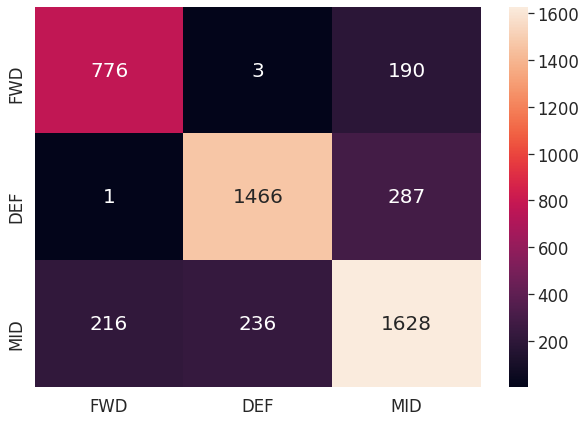

In [109]:
# creating a heatmap from the confusion matrix
import seaborn as sn 
labels = ['FWD', 'DEF', 'MID'] # specifying the labels in our data based on encoding
#creating a dataframe from the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix[0], index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # setting the label size
# drawing the heat map along with displaying values in a digit format and setting the digit size
sn.heatmap(confusion_df, annot=True, fmt='d', annot_kws={'size': 20})


### 3.3 K-fold Cross-Validation
***

For prediction, we create a dataframe containing only relevant columns to shorten the prediction time.

In [ ]:
df_final_prediction = df_kmeans_pred[['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Cluster', 'Position_Group']]

In [72]:
df_kmeans_pred.show(5)

+------+-------+-------------+---+--------------------+-----------+--------------------+------------+--------------+--------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+--------------+
|    ID|Cluster|         Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|                Club|           Club Logo|Valu

In [74]:
# writing to a csv file
df_kmeans_pred.coalesce(1).write.format('com.databricks.spark.csv').option('header',True).save('/content/custom_csv.csv')
!ls /content/custom_csv.csv

part-00000-9664fe47-f1e1-4ec7-8462-e5e2966d7be7-c000.csv  _SUCCESS


In [79]:
# moving and renaming the saved csv file as the same time
#!mv "/content/custom_csv.csv/part-00000-9664fe47-f1e1-4ec7-8462-e5e2966d7be7-c000.csv" "/content/FIFA_new.csv"
df_final = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_new.csv')
df_final.show(5)

+------+-------+-------------+---+--------------------+-----------+--------------------+------------+--------------+--------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+--------------+
|    ID|Cluster|         Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|                Club|           Club Logo|Valu

In [ ]:
df_kmeans_pred.show(5)

+------+-------+-------------+---+--------------------+-----------+--------------------+------------+--------------+--------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+--------------+
|    ID|Cluster|         Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|                Club|           Club Logo|Valu

In [ ]:
print((df_test.count(), len(df_test.columns)))

(16122, 70)


In [ ]:
print((df_kmeans_pred.count(), len(df_kmeans_pred.columns)))

(16122, 70)


In this section, we perform hyper-parameter tuning to find the best hyper-parameter set using K-fold cross validation along with param grid. 

In [80]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import encoder

Preprocessing Stages:

Setting the pipeline

In [81]:
# creating the preprocessing stages for the Machine Learning pipeline and setting the pipeline
# defining the stage 1
vec_assembler_mlp = VectorAssembler(inputCols=features_col, outputCol='features')
# defining the stage 2
standard_scaler_mlp = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
# defining the stage 3
encoding_mlp = encoder.LabelEncoder()
# defining the last stage (random forest)
random_forest = RandomForestClassifier(labelCol='Target', featuresCol='Scaled_features', numTrees=20, maxDepth=5,\
                                       impurity='gini')
# defining the last stage (logistic regression)
logistic_regression = LogisticRegression(featuresCol='Scaled_features', labelCol='Target', maxIter=100, regParam=0, threshold=0.5)
# defining the last stage (decision tree)
decision_tree = DecisionTreeClassifier(featuresCol='Scaled_features', labelCol='Target', maxDepth=5, maxBins=32, impurity='gini')


# setting the pipeline for random_forest
pipeline_random_forest = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, random_forest])
# setting the pipeline for logistic_regression
pipeline_logistic_regression = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, logistic_regression])
# setting the pipeline for decision tree
pipeline_decision_tree = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, decision_tree])

Buidling parameter grids

In [82]:
# building a grid of parameters for random forest to be used by the cross-
# providing number of trees, depth of trees and impurity measures as inputs for parameter grids
paramGrid_random_forest = ParamGridBuilder().addGrid(random_forest.numTrees, [5, 10, 20, 40])\
.addGrid(random_forest.maxDepth, [4,14,24])\
.addGrid(random_forest.impurity, ['entropy', 'gini']).build()

# building a grid of parameters for logistic regression to be used by the cross-validation
# providing iteration number, different lambda values and threshold values for paramter grids
paramGrid_logistic_regression = ParamGridBuilder().addGrid(logistic_regression.maxIter, [50, 100, 200, 250])\
.addGrid(logistic_regression.regParam, [0.1,0, 1, 10]).build()

# building a grid of parameters for decision tree to be used by the cross-validation
# providing various maxBins, maxDepth and impurity values as parameters
paramGrid_decision_tree = ParamGridBuilder().addGrid(decision_tree.maxDepth, [5, 10, 20, 30])\
 .addGrid(decision_tree.maxBins, [15, 25, 32])\
 .addGrid(decision_tree.impurity, ['entropy', 'gini']).build()

Splitting the dataset

In [85]:
# splitting the data into training and testing dataset
training, testing = df_final.randomSplit([0.7, 0.3], seed=2020)

In [86]:
print((training.count(), len(training.columns)))

(11363, 70)


In [ ]:
print((training.count(), len(training.columns)))

(11319, 70)


**Cross validation**




Cross validating the random forest

In [87]:
# cross validating for random forest
crossval_random_forest = CrossValidator(estimator=pipeline_random_forest,\
                          estimatorParamMaps=paramGrid_random_forest,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)

# fitting the training data
cv_random_forest= crossval_random_forest.fit(training)

Displaying the parameter values with scores along with finding the best parameter values and fitting the testing dataset

In [88]:
# creating a dictionary of parameter and values after retrieving the estimator parameter map
parameter_values_rf = [{parameter.name: values for parameter, values in parameter_maps.items()} for parameter_maps in cv_random_forest.getEstimatorParamMaps()]
#print(parameter_values_rf)
# creating a pandas dataframe containing measuring scores corresponding to each parameter value for different parameters from a dictionary 
# the first column is the score and the remaining are the parameters
pd.DataFrame.from_dict([{cv_random_forest.getEvaluator().getMetricName(): metric, **pvs}\
    for pvs, metric in zip(parameter_values_rf, cv_random_forest.avgMetrics)
])

,f1,numTrees,maxDepth,impurity
0,0.778420,5,4,entropy
1,0.790429,5,4,gini
2,0.834875,5,14,entropy
3,0.834080,5,14,gini
4,0.830326,5,24,entropy
5,0.828899,5,24,gini
6,0.805837,10,4,entropy
7,0.810868,10,4,gini
8,0.853937,10,14,entropy
9,0.846169,10,14,gini


In [89]:
# printing the parameter values for the best estimator
print(cv_random_forest.getEstimatorParamMaps()[np.argmax(cv_random_forest.avgMetrics)])

{Param(parent='RandomForestClassifier_a33bebc2371b', name='numTrees', doc='Number of trees to train (>= 1).'): 40, Param(parent='RandomForestClassifier_a33bebc2371b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 14, Param(parent='RandomForestClassifier_a33bebc2371b', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy'}


In [90]:
# fitting the training data using the best model
prediction_random_forest = cv_random_forest.bestModel.transform(testing).select('Target', 'prediction')
prediction_random_forest.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
|     2|       0.0|
|     2|       2.0|
|     2|       1.0|
|     1|       2.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
|     1|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       2.0|
+------+----------+
only showing top 20 rows



In [125]:
confusion_matrix_random_forest = calculate_confusion_matrix(prediction_random_forest)
#confusion_matrix_random_forest

Precision for FWD is 84.45
Recall for FWD is 76.19
F1-score for FWD is 80.11

Precision for DEF is 91.72
Recall for DEF is 92.89
F1-score for DEF is 92.3

Precision for MID is 83.3
Recall for MID is 86.37
F1-score for MID is 84.81



In [111]:
confusion_matrix_random_forest

(array([[ 755,    6,  230],
        [   0, 1606,  123],
        [ 139,  139, 1761]], dtype=int32),
 (0.8445190156599552, 0.7618567103935419, 0.8010610079575596),
 (0.9171901770416905, 0.9288606130711394, 0.9229885057471265),
 (0.8330179754020813, 0.8636586562040216, 0.8480616421863713))

Cross validating the logistic regression

In [93]:
# cross validating for logistic regression
crossval_logistic_regression = CrossValidator(estimator=pipeline_logistic_regression,\
                          estimatorParamMaps=paramGrid_logistic_regression,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)

# fitting the training dataset
cv_logistic_regression = crossval_logistic_regression.fit(training)

In [94]:
# fitting the training data using the best model
prediction_logistic_regression = cv_logistic_regression.bestModel.transform(testing).select('Target', 'prediction')
prediction_logistic_regression.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
|     2|       2.0|
|     2|       2.0|
|     2|       1.0|
|     1|       2.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
|     1|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       2.0|
+------+----------+
only showing top 20 rows



In [126]:
confusion_matrix_logistic_regression = calculate_confusion_matrix(prediction_logistic_regression)

Precision for FWD is 82.51
Recall for FWD is 79.01
F1-score for FWD is 80.72

Precision for DEF is 92.25
Recall for DEF is 91.61
F1-score for DEF is 91.93

Precision for MID is 83.42
Recall for MID is 85.63
F1-score for MID is 84.51



In [113]:
confusion_matrix_logistic_regression

(array([[ 783,    6,  202],
        [   0, 1584,  145],
        [ 166,  127, 1746]], dtype=int32),
 (0.8250790305584826, 0.7901109989909183, 0.8072164948453608),
 (0.9225393127548049, 0.9161364950838635, 0.9193267556587348),
 (0.8342092689918776, 0.8563021088769004, 0.8451113262342691))

Cross validating the Decision Tree

In [98]:
# cross validating for decision tree
crossval_decision_tree = CrossValidator(estimator=pipeline_decision_tree,\
                          estimatorParamMaps=paramGrid_decision_tree,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)
# fitting the training dataset
cv_decision_tree = crossval_decision_tree.fit(training)

In [99]:
# fitting the training data using the best model
prediction_decision_tree = cv_decision_tree.bestModel.transform(testing).select('Target', 'prediction')
prediction_decision_tree.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       1.0|
|     1|       2.0|
|     0|       0.0|
|     2|       0.0|
|     2|       2.0|
|     0|       2.0|
|     1|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       2.0|
+------+----------+
only showing top 20 rows



In [127]:
confusion_matrix_decision_tree = calculate_confusion_matrix(prediction_decision_tree)

Precision for FWD is 76.57
Recall for FWD is 73.86
F1-score for FWD is 75.19

Precision for DEF is 88.68
Recall for DEF is 88.78
F1-score for DEF is 88.73

Precision for MID is 78.96
Recall for MID is 80.24
F1-score for MID is 79.59



Creating tables or dataframes to compare the performance of different classifiers.

In [248]:
# creating a new dataframe from list of classifers
classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
df_classifier = spark.createDataFrame([(l,) for l in classifiers], ['Classifier'])

In [250]:
# populating the data for dataframes containing performance indicators
data_fwd = [confusion_matrix_random_forest[1], confusion_matrix_random_forest[2], \
        confusion_matrix_random_forest[3]]
data_def = [confusion_matrix_logistic_regression[1], confusion_matrix_logistic_regression[2], \
        confusion_matrix_logistic_regression[3]]
data_mid = [confusion_matrix_decision_tree[1], confusion_matrix_decision_tree[2], \
        confusion_matrix_decision_tree[3]]

In [252]:
# defining the schema of the dataframes containing performance metrics
from pyspark.sql.types import StructType, StructField, StringType
schema = StructType([
    StructField('Precision', FloatType(), False),
    StructField('Recall', FloatType(), False),
    StructField('F1-score', FloatType(), False)
    ])

In [253]:
# creating dataframes
fwd_df = spark.createDataFrame(data_fwd, schema)
def_df = spark.createDataFrame(data_def, schema)
mid_df = spark.createDataFrame(data_mid, schema)
print('Forwards:')
fwd_comparison_df.show()

#def_comparison_df = spark.createDataFrame(data_def, schema)
#print('Defenders:')
#def_comparison_df.show()

#mid_comparison_df = spark.createDataFrame(data_mid, schema)
#print('Midfielders:')
#mid_comparison_df.show()

Forwards:
+---------+------+--------+
|Precision|Recall|F1-score|
+---------+------+--------+
|    84.45| 76.19|   80.11|
|    91.72| 92.89|    92.3|
|     83.3| 86.37|   84.81|
+---------+------+--------+



In [261]:
# adding index to the dataframes to join later
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
fwd_comparison_df = fwd_comparison_df.withColumn("row_index", row_number().over(Window.orderBy(monotonically_increasing_id())))
df_classifier = df_classifier.withColumn("row_index", row_number().over(Window.orderBy(monotonically_increasing_id())))
final_df = df_classifier.join(fwd_comparison_df, fwd_comparison_df.row_index == df_classifier.row_index).drop("row_index")

In [262]:
final_df.show()

+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    84.45| 76.19|   80.11|
|Logistic Regression|    91.72| 92.89|    92.3|
|      Decision Tree|     83.3| 86.37|   84.81|
+-------------------+---------+------+--------+



In [273]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

def comparison_table(confusion_matrix_a, confusion_matrix_b, confusion_matrix_c, pos):
  # creating a new dataframe from list of classifiers
  classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
  df_classifier = spark.createDataFrame([(l,) for l in classifiers], ['Classifier'])

  # stating conditions to select data based on player positions
  if pos == 'FWD':
    index = 1
  elif pos == 'DEF':
    index = 2
  elif pos == 'MID':
    index = 3

  # populating the data for dataframes containing performance indicators
  data_pos = [confusion_matrix_a[index], confusion_matrix_b[index], confusion_matrix_c[index]]
  
  # defining the schema of the dataframes containing performance metrics
  schema = StructType([
      StructField('Precision', FloatType(), False),
      StructField('Recall', FloatType(), False),
      StructField('F1-score', FloatType(), False)
      ])
  
  # creating a dataframe for performance metrics
  pos_df = spark.createDataFrame(data_pos, schema)

  # adding index to the dataframes to join later
  pos_df = pos_df.withColumn("row_index", row_number().over(Window.orderBy(monotonically_increasing_id())))
  df_classifier = df_classifier.withColumn("row_index", row_number().over(Window.orderBy(monotonically_increasing_id())))
  comparison_df = df_classifier.join(pos_df, pos_df.row_index == df_classifier.row_index).drop("row_index")
  
  return comparison_df

In [274]:
print('Forwards:')
comparison_table(confusion_matrix_random_forest, confusion_matrix_logistic_regression, \
                 confusion_matrix_decision_tree, 'FWD').show()

print('Defenders:')
comparison_table(confusion_matrix_random_forest, confusion_matrix_logistic_regression, \
                 confusion_matrix_decision_tree, 'DEF').show()
print('Midfielders:')
comparison_table(confusion_matrix_random_forest, confusion_matrix_logistic_regression, \
                 confusion_matrix_decision_tree, 'MID').show()                

Forwards:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    84.45| 76.19|   80.11|
|Logistic Regression|    82.51| 79.01|   80.72|
|      Decision Tree|    76.57| 73.86|   75.19|
+-------------------+---------+------+--------+

Defenders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    91.72| 92.89|    92.3|
|Logistic Regression|    92.25| 91.61|   91.93|
|      Decision Tree|    88.68| 88.78|   88.73|
+-------------------+---------+------+--------+

Midfielders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|     83.3| 86.37|   84.81|
|Logistic Regression|    83.42| 85.63|   84.51|
|      Decision Tree|    78.96| 80.24|   79.59|
+---